# **GenAI Empowered Script to Storyboard Generator**

**The research presents an innovative solution for
automating the generation of storyboards from screenplays through the integration of advanced AI technologies. By taking a screenplay as input, the system utilizes cutting-edge neural
networks to recognize characters and objects, enhancing scene
comprehension. A refined Bi LSTM model is employed to extract
the nuanced emotional tones embedded within each scene, pro-
viding valuable insights into character dynamics and narrative
depth. Through the application of regular expressions, key scene
attributes such as time, place, and location are extracted to
establish contextual relevance. A Transformer based model,
led-large-book-summary, is then utilized to generate concise
summaries of each scene, facilitating efficient comprehension.
Through script summarization and tag extraction from the Movie
Plot Synopses with Tags dataset, a smooth transition between
scenes is enabled. These extracted features are structured into
a prompt using a rule based approach, facilitating seamless
integration into the subsequent creative phase. Finally, a stable
diffusion model is employed to generate scene-by-scene coherent
storyboard, incorporating all extracted elements to streamline the
visual storytelling process where coherency is achieved with the
help of cosine similarity between prompts. This comprehensive
approach not only automates tedious tasks but also enhances
creativity and efficiency in storyboard creation.**

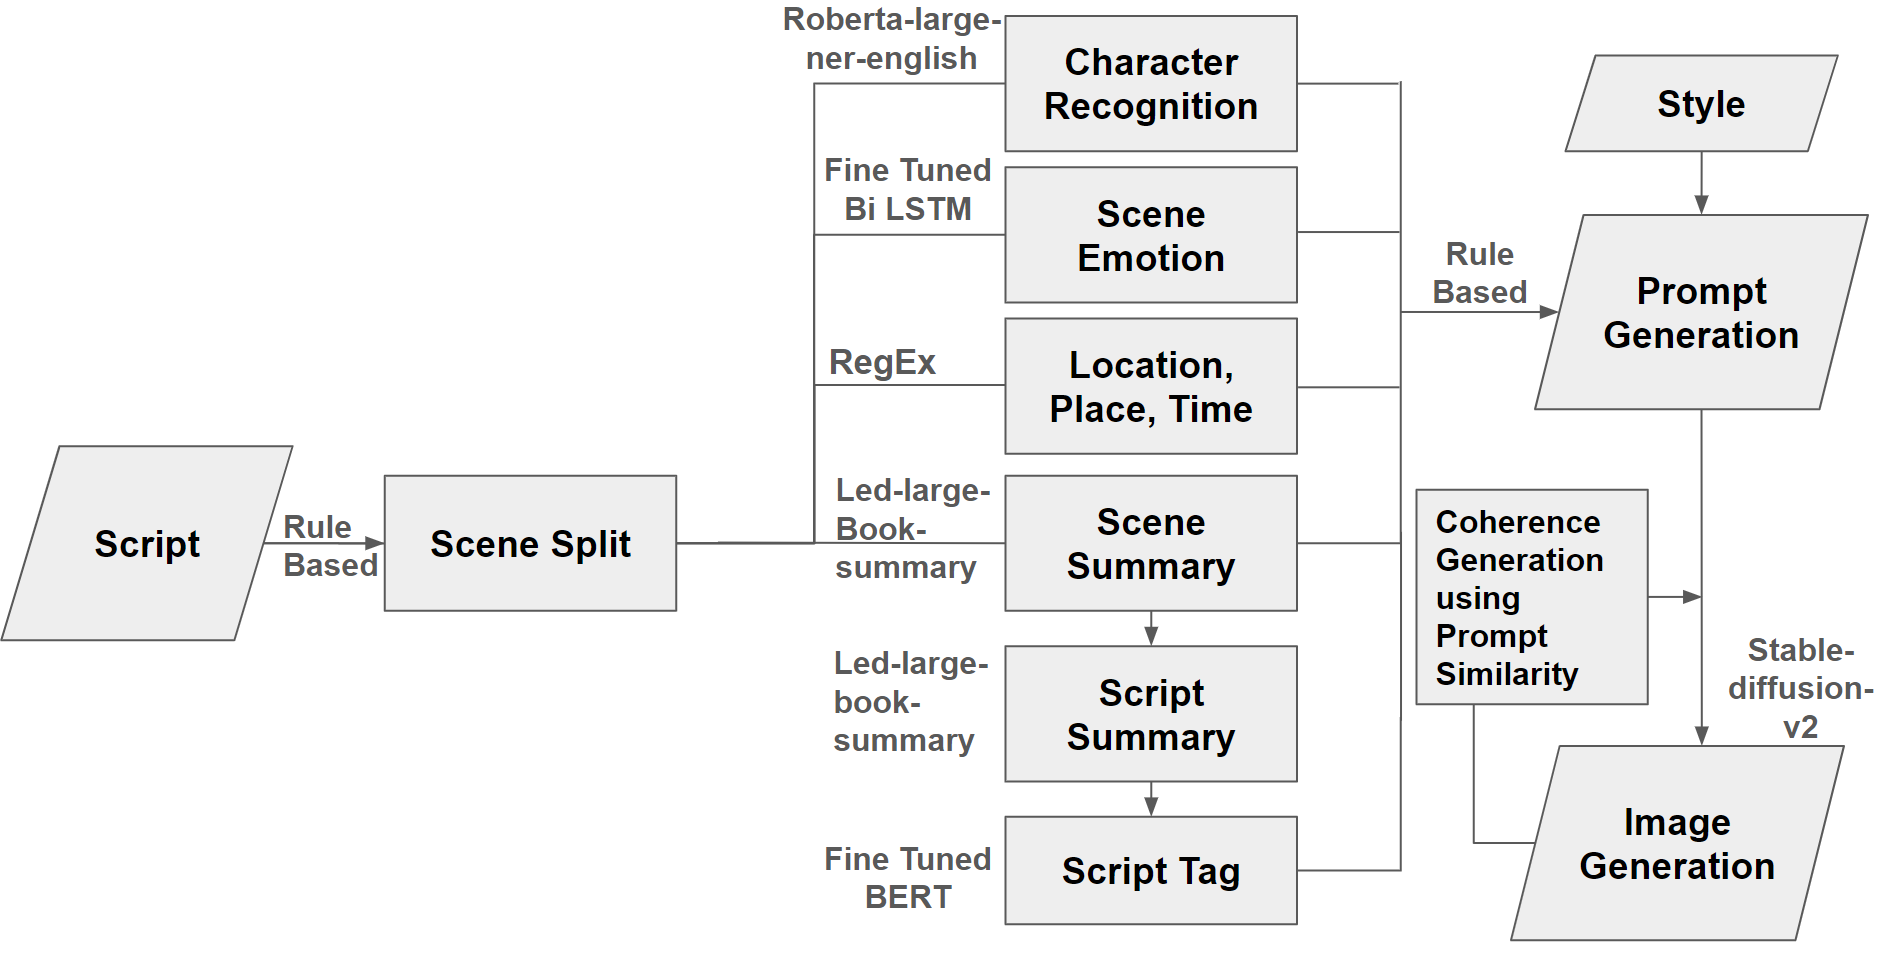

# **Installing Packages**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drivedir = r'/content/drive/MyDrive/GenAI/'

Mounted at /content/drive


In [ ]:
!pip install -r /content/drive/MyDrive/GenAI/requirements.txt

#GenAI Empowered Script to Storyboard Generator

In the cinematic realm, transitioning from a screenplay to visual representation has traditionally been labor-intensive, requiring meticulous attention from storyboard artists and filmmakers. Leveraging recent advancements in Artificial Intelligence (AI) and Natural Language Processing (NLP), our project bridges traditional methods with AI-driven technologies. We propose a comprehensive solution that automates storyboard generation from screenplays, integrating advanced AI models like neural networks and transformers. This approach not only streamlines filmmaking but also enhances creativity and efficiency. Through empirical evaluations and case studies, we demonstrate the transformative potential of our method in reshaping the art of cinematic storytelling.

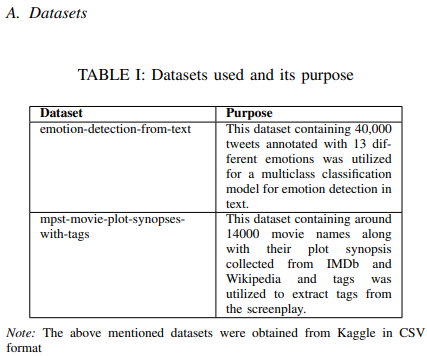

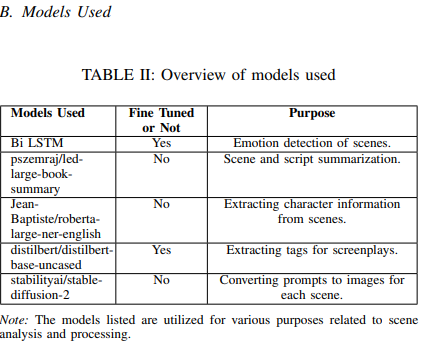

In [ ]:
import torch
import re
import os
import pdfplumber
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from io import BytesIO
from transformers import pipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoModelForTokenClassification, AutoModel
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler, StableDiffusionImg2ImgPipeline
from transformers import BertTokenizer, BertForSequenceClassification
import nltk
from nltk.tokenize import word_tokenize
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **SCRIPT LOADING**

In [ ]:
scriptdir = os.path.join(drivedir, "Script")
contents = os.listdir(scriptdir)
print("Contents of", scriptdir)
for item in contents:
    print(item)

Contents of /content/drive/MyDrive/GenAI/Script
jaws.pdf
reservoir-dogs-1992_removed.pdf
jojo-rabbit-final-script_removed.pdf
short_film_script_2.pdf
fivefeetandrising.pdf


In [ ]:
pdfname = "fivefeetandrising.pdf"

text = ""
with pdfplumber.open(os.path.join(drivedir, "Script", pdfname)) as pdf:
    for page in pdf.pages:
        text += page.extract_text()
text

'FIVE FEET AND RISING\nby\nPeter Sollett\nFADE IN:\nEXT. 8TH STREET BETWEEN AVENUES C AND D - DAY\nA group of dark-skinned girls wearing cheerleading outfits\nalign themselves in formation on the sidewalk. They begin to\ndance. No music can be heard. The sound of the girls\' bodies\nis our soundtrack. We hear their strained breathing, palms\nand sneaker bottoms pounding while they hum and count softly\nto themselves in an effort to keep the rhythm.\nSLO-MO: We explore the bodies of the dancers; their bright\neyes and sweaty brows, their stomping feet and colliding\nhands (dark side and light side). The younger girls perform\nprovocative dance movements, the older girls repeat them.\nTheir bodies silhouette in the bright sunlight.\nCUT TO: TITLES\nEXT. AMANDA\'S BLOCK - DAY\nAMANDA, a tall 14-year-old exits the front door of her\napartment budding with her headphones in one hand and a\nmagazine in the other. She sits down on her stoop, puts her\nheadphones on and presses "play". We can 

# **SCENE SPLITTING**


The process of detecting scene changes involves parsing the screenplay text to locate specific shot headings, such as "INT" or "EXT," which denote changes in location or setting. Using a rule-based approach, the script is then segmented based on these shot headings, with each segment representing a distinct scene. This segmentation continues iteratively, with the content between successive shot headings stored as individual scenes until the entire screenplay is processed, resulting in a comprehensive breakdown of the script into cohesive scenes.

In [ ]:
#text= re.sub(r"<.?\/>", '.', text)
#text= re.sub(r"[\n]", ".", text)
#text= re.sub(r"[\t]", " ", text)
tokens= word_tokenize(text)
print(tokens)

['FIVE', 'FEET', 'AND', 'RISING', 'by', 'Peter', 'Sollett', 'FADE', 'IN', ':', 'EXT', '.', '8TH', 'STREET', 'BETWEEN', 'AVENUES', 'C', 'AND', 'D', '-', 'DAY', 'A', 'group', 'of', 'dark-skinned', 'girls', 'wearing', 'cheerleading', 'outfits', 'align', 'themselves', 'in', 'formation', 'on', 'the', 'sidewalk', '.', 'They', 'begin', 'to', 'dance', '.', 'No', 'music', 'can', 'be', 'heard', '.', 'The', 'sound', 'of', 'the', 'girls', "'", 'bodies', 'is', 'our', 'soundtrack', '.', 'We', 'hear', 'their', 'strained', 'breathing', ',', 'palms', 'and', 'sneaker', 'bottoms', 'pounding', 'while', 'they', 'hum', 'and', 'count', 'softly', 'to', 'themselves', 'in', 'an', 'effort', 'to', 'keep', 'the', 'rhythm', '.', 'SLO-MO', ':', 'We', 'explore', 'the', 'bodies', 'of', 'the', 'dancers', ';', 'their', 'bright', 'eyes', 'and', 'sweaty', 'brows', ',', 'their', 'stomping', 'feet', 'and', 'colliding', 'hands', '(', 'dark', 'side', 'and', 'light', 'side', ')', '.', 'The', 'younger', 'girls', 'perform', 'pro

In [ ]:
scenes= []
split= ["INT", "EXT", "INT.", "EXT.", "INTERIOR", "EXTERIOR"]
for i in range(len(tokens)):
  scn= ""
  if tokens[i] in split:
    scn+= tokens[i]+" "
    i+= 1

    while i<len(tokens):
      if tokens[i] in split:
        break
      else:
        scn+= tokens[i]+" "
        i+= 1
        if i>len(tokens)-1:
          break
    scenes.append(scn)
print("Number of scenes: "+str(len(scenes)))

Number of scenes: 27


# **LOCATION, PLACE, TIME**


Shot headings in the screenplay are analyzed using regular expressions to extract location, place, and time information. Regular expressions, which check for specific patterns within text, enable precise extraction of data due to the standardized format of shot headings in screenplays.

In [ ]:
fscene= []
details= []
for scene in scenes:
  det= []
  cont= ""
  location= "EXTERIOR" if(scene[0:3]=="EXT")else "INTERIOR"
  det.append(location)

  match= re.search(r'[.\s-]\s*([A-Z\s]+)\s*-', scene)
  place=match.group(1) if match else ""
  det.append(place)

  match= re.search(r'[-.][^-]+-\s*(\w+)\s', scene)
  time=match.group(1) if match else ""
  det.append(time)

  details.append(det)
  start_index= scene.find(time)
  if start_index != -1:
      remscene= scene[start_index+len(time):]
  cont= remscene
  fscene.append(cont)
print(fscene)

[" A group of dark-skinned girls wearing cheerleading outfits align themselves in formation on the sidewalk . They begin to dance . No music can be heard . The sound of the girls ' bodies is our soundtrack . We hear their strained breathing , palms and sneaker bottoms pounding while they hum and count softly to themselves in an effort to keep the rhythm . SLO-MO : We explore the bodies of the dancers ; their bright eyes and sweaty brows , their stomping feet and colliding hands ( dark side and light side ) . The younger girls perform provocative dance movements , the older girls repeat them . Their bodies silhouette in the bright sunlight . CUT TO : TITLES ", " AMANDA , a tall 14-year-old exits the front door of her apartment budding with her headphones in one hand and a magazine in the other . She sits down on her stoop , puts her headphones on and presses `` play '' . We can hear the sound of Salsa leaking out of the sides of her headphones . JENETTE , ten years old with big black ha

# **CHARACTER RECOGNITION**


Character identification relies on fine-tuning models like roberta-large on the CoNLL 2003 dataset, validated on chat data, excelling particularly with non-uppercase entities. Personal (PER) entity recognition aids in scene character extraction.

In [ ]:
ner_tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/roberta-large-ner-english")
ner_model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/roberta-large-ner-english")

tokenizer_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/849 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [ ]:
nlp = pipeline('ner', model=ner_model, tokenizer=ner_tokenizer, aggregation_strategy="simple")
characters= []
for scene in fscene:
  char= []
  result= nlp(scene)

  if result==[]:
    char.append("Absent")
  else:
    for i in range(len(result)):
      if result[i]['entity_group']=="PER":
        if result[i]["word"].upper() not in char:
          char.append(result[i]["word"].upper())
  characters.append(char)
print(characters)

[['Absent'], [' AMANDA', ' JENETTE', ' AARON', ' DONNA', ' MICHELLE', ' HECTOR', ' HECTORY'], [' VICTOR', ' CARLOS', ' CARL', 'S'], [' VICTOR', ' CARLOS', ' CARLOS NATASHA', ' MARIA', ' TINA', ' CARLOS PITT'], [' VICTOR', ' CARLOS'], [' VICTOR', ' CARLOS'], [' AMANDA', ' JENETTE', 'AN', ' HOOCHIE', 'JENETTE', ' CARLOS', ' VICTOR', ' EDDIE', 'ICTOR EDDIE', ' BARUCH', ' AARON', ' DONNA', ' VICTOR VICTOR', ' HECTOR'], [' AARON', ' AL PACINO', ' DARRELL', ' DONNA', ' MICHELLE', ' DONNA AARON', ' DONNA GOD', ' PACINO'], [' VICTOR', ' CARLOS', ' AMANDA', ' HECTOR'], [' HECTOR', ' AMANDA', ' JENETTE'], [' AMANDA', ' VICTOR', 'CARLOS', ' AMAN', 'AN', ' HECTOR'], [' AMANDA', ' VICTOR'], [' ERICA', ' FANTASY', ' SHAI', ' DIAMOND', ' FRANCESCA', ' MELODY', ' CARLOS', ' VICTOR', 'ICTOR', ' EDDIE', 'ICTOR EDDIE', ' MOMS'], [' VICTOR', ' AMANDA'], [' DONNA', ' MICHELLE', ' AARON'], [' AARON', ' MICHELLE', ' DONNA', ' VICTOR', ' SHORT'], [' VICTOR', ' JENETTE', ' AMANDA', ' AARON', 'EN', 'ICTOR', 'EN

# **EMOTION CLASSIFICATION**

Scene identification involves loading and exploring tweet datasets for emotions, preprocessing, constructing a Bidirectional LSTM model with GloVe embeddings, training with suitable functions and checkpointing, evaluating with metrics, saving the model, and defining a prediction function for emotion classification in user text, encompassing various emotions.

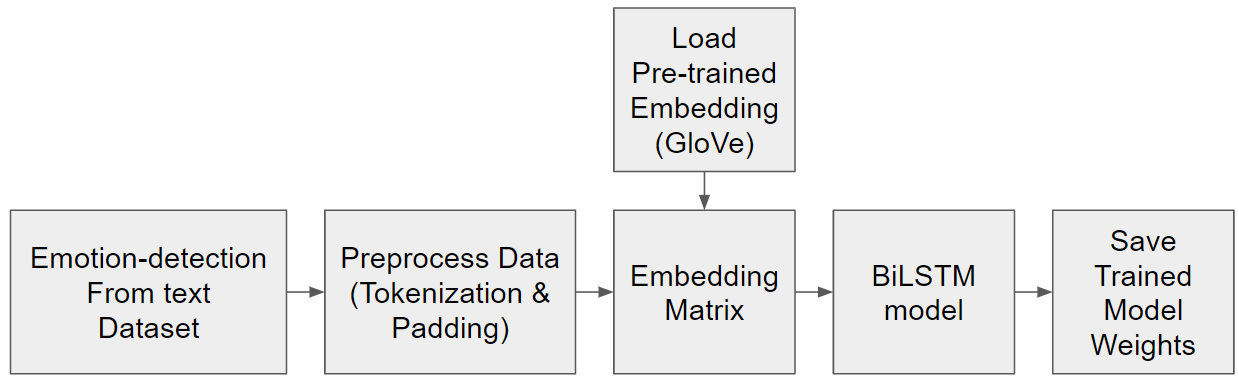

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/GenAI/Emotion/tweet_emotions.csv')

emo_tokenizer = Tokenizer()
emo_tokenizer.fit_on_texts(data['content'])
sequences = emo_tokenizer.texts_to_sequences(data['content'])

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['sentiment'])

max_length = max([len(seq) for seq in sequences])

def preprocess_input_text(text):
    sequence = emo_tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)
    return padded_sequence


emotion_model_path = "/content/drive/MyDrive/GenAI/Emotion/best_model.h5"
emotion_model = load_model(emotion_model_path)


def predict_emotion(text):
    preprocessed_text = preprocess_input_text(text)
    prediction = emotion_model.predict(preprocessed_text)

    predicted_index = np.argmax(prediction)
    predicted_emotion = label_encoder.classes_[predicted_index]
    return predicted_emotion

In [ ]:
emotions= []
for scene in fscene:
  prediction= predict_emotion(scene)
  emotions.append(prediction)
len(emotions)

1/1 [==============================] - 0s 21ms/step


27

# **SCENE SUMMARY**

scene summarization begins with the screenplay being split into scenes and relevant information extracted. This data is then summarized using a Transformer-based model, led-large-book-summary, fine-tuned on the BookSum dataset. Initialized from bart-large due to identical architecture, it utilizes bart-large's position embedding matrix to process up to 16000 tokens, aiming for generalization and effective summarization of lengthy text. The maximum summary length is capped at 100 tokens to facilitate prompt generation for storyboard creation.

In [ ]:
summarizer= pipeline("summarization", model="facebook/bart-large-cnn")

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
sumscene= []
for n, scene in enumerate(fscene):
  print(f"Summarising Scene {n+1}")
  summary_text= summarizer(scene, max_length=60)
  print(summary_text)
  sumscene.append(summary_text[0]["summary_text"])
len(sumscene)

Summarising Scene 1
[{'summary_text': "A group of dark-skinned girls wearing cheerleading outfits align themselves in formation on the sidewalk. The sound of the girls ' bodies is our soundtrack. We explore the bodies of the dancers; their bright eyes and sweaty brows. Their stomping feet and colliding hands ( dark side"}]
Summarising Scene 2
[{'summary_text': "Amanda, a tall 14-year-old, exits the front door of her apartment budding with her headphones in one hand and a magazine in the other. She sits down on her stoop , puts her headphones on and presses `` play '' The camera pans to reveal AARON"}]
Summarising Scene 3
[{'summary_text': 'Carlos, a skinny 12-year-old with sloppy hair, is asleep in the sun on his fire escape. He immediately grabs Carlos and starts pushing him down the block to avoid being seen from above. Victor climbs down the fire escape and hops down to the street.'}]
Summarising Scene 4
[{'summary_text': 'The boys safely round the corner onto Avenue D. Victor perks

Your max_length is set to 60, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


[{'summary_text': "Carlos stands in front of the singers mocking them. Victor leans into Carlos, resting his arm on Carlos ' shoulder. Carlos shrugs Victor off as he walks away down the block. A moment passes . Carlos ( to himself ) What do you do when your bitch is untrue ? You"}]
Summarising Scene 14
[{'summary_text': "Victor 's trip through the streets in search of Amanda's block. Victor and Amanda go on a road trip through New York City. Victor finds a block and heads to Amanda's house to meet up with her. The pair have a great time together and get to know each other"}]
Summarising Scene 15
[{'summary_text': 'Donna and Michelle are standing in front of their building. Michelle places one hand on her side , the other in the air and begins to step. Michelle grabs Donna , they embrace and dance. Michelle looks over her shoulder . Aaron isdrinking a bottle of soda across the street.'}]
Summarising Scene 16
[{'summary_text': "Aaron sits on a stoop across the street from Michelle and Do

Your max_length is set to 60, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


[{'summary_text': "Victor finds Jenette sitting on Amanda 's stoop. She appears to have just come outside as she unties a jump rope. Victor stands next to her for a moment waiting awkwardly to speak. Hector approaches Victor from down the block. Victor looks at Hector then walks away down"}]
Summarising Scene 18
[{'summary_text': "Victor rounds the corner and sits down on the sidewalk. VICTOR ( to himself ) Fuck man . I 'm gon na get a fuckin ' M-80 and shove it up his retarded ass .  Victor rounds the corners and sits on the street corner."}]
Summarising Scene 19
[{'summary_text': 'Chris, an energetic ten-year-old, exits the front door of his building holding a bat. As the camera pans , we see Aaron on the corner talking to Mari. Chris rubs his eyes , turns around and looks up at one of the windows in his building.'}]
Summarising Scene 20
[{'summary_text': "Aaron is sitting on the sidewalk crushing a soda bottle under his foot. Aaron stands up and tosses the ball back to Chris , thenl

27

In [ ]:
device = "cuda"
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased").to(device)

def bert_vectorizer(scenes):
  vectors=[]
  for scene in scenes:
    tokens = bert_tokenizer(scene, return_tensors="pt")
    with torch.no_grad():
        output = bert_model(**tokens.to(device))
    vectors.append(output.last_hidden_state[:, 0, :].cpu().numpy())
  return vectors

scene_vectors=bert_vectorizer(sumscene)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# **SCRIPT SUMMARY**

Script summarization employs a Transformer-based model, led-large-book-summary, to derive a summary of the script. Given the token input limitation, the entire script cannot be processed at once. Instead, summaries of individual scenes are concatenated and fed into the model to generate the movie synopsis, enabling efficient extraction of the plot from the script.

In [ ]:
script= " ".join([i for i in sumscene])

In [ ]:
final_summary= summarizer(scene, max_length=150)[0]["summary_text"]
final_summary

"Amanda walks through the half-open fence and leans flat against the wall. Victor stands close by, nervously . He keeps his distance from her. Amanda takes Victor 's hand and places it on her breast. She wraps her arms around his waist. Victor bends his arms around her back. Amanda hisses him on the lips."

# **Tag Generation**

Script tagging involves fine-tuning a BERT model on a multitag classification dataset of plot synopses and associated tags. After preprocessing and encoding, the model is trained using the AdamW optimizer and linear scheduler, with data loaded into loaders for training and validation. The model is evaluated for accuracy and saved for inference. It predicts tags for synopses using a provided function. Script tags include categories like 'cult,' 'horror,' 'gothic,' 'murder,' 'atmospheric,' or 'violence.'

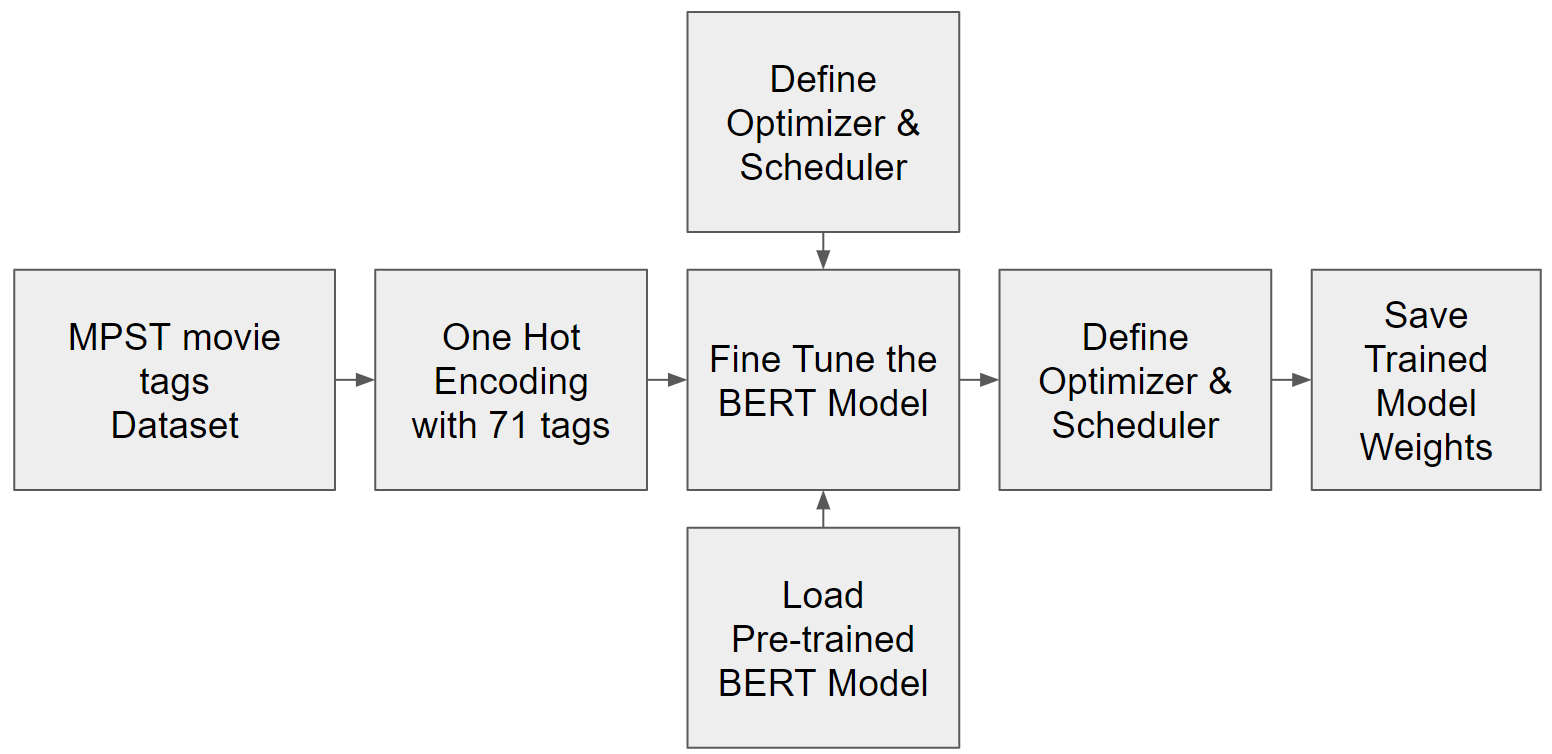

In [ ]:
target_list= ['neo noir', 'stupid', 'blaxploitation', 'allegory', 'atmospheric', 'home movie', 'historical fiction', 'thought-provoking', 'adult comedy', 'melodrama', 'dark', 'western', 'cruelty', 'action', 'autobiographical', 'sadist', 'avant garde', 'storytelling', 'prank', 'realism', 'good versus evil', 'psychological', 'magical realism', 'horror', 'clever', 'philosophical', 'whimsical', 'revenge', 'gothic', 'boring', 'sentimental', 'depressing', 'dramatic', 'christian film', 'brainwashing', 'anti war', 'tragedy', 'comic', 'intrigue', 'pornographic', 'sci-fi', 'suicidal', 'absurd', 'non fiction', 'cute', 'claustrophobic', 'inspiring', 'romantic', 'entertaining', 'fantasy', 'psychedelic', 'alternate history', 'humor', 'flashback', 'plot twist', 'comedy', 'bleak', 'grindhouse film', 'satire', 'murder', 'feel-good', 'mystery', 'haunting', 'suspenseful', 'insanity', 'cult', 'queer', 'violence', 'alternate reality', 'paranormal', 'historical']

def predict_tags_from_text(text):
    # Load tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(target_list))
    model.load_state_dict(torch.load(r'/content/drive/MyDrive/GenAI/ONE LINE/tag_model.pth', map_location=torch.device('cpu')))  # Load the trained model

    max_len = 256  # Max length of input text

    inputs = tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_tags = torch.sigmoid(logits)

    tags = {}
    for i, tag in enumerate(target_list):
        tags[tag] = predicted_tags[0][i].item()

    return tags

predicted_tags = predict_tags_from_text(final_summary)
maxtag = max(predicted_tags, key=predicted_tags.get)

print(maxtag, predicted_tags[maxtag])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


murder 0.38793811202049255


# **STYLE SELECTION**

Users can specify the desired style, such as 'pencil drawing,' 'sketch,' 'cartoon,' 'animation,' or 'photoreal.

In [ ]:
from IPython.display import HTML, display

html_code = """
<!DOCTYPE html>
<html>
<head>
  <title>Options</title>
</head>
<body>
  <h2>Select an Option:</h2>
  <form>
    <input type="radio" id="pencil" name="option" value="pencil">
    <label for="pencil">Pencil Drawing</label><br>
    <input type="radio" id="sketch" name="option" value="sketch">
    <label for="sketch">Sketch</label><br>
    <input type="radio" id="cartoon" name="option" value="cartoon">
    <label for="cartoon">Cartoon</label><br>
    <input type="radio" id="animation" name="option" value="animation">
    <label for="animation">Animation</label><br>
    <input type="radio" id="photoreal" name="option" value="photoreal">
    <label for="photoreal">Photoreal</label><br><br>
    <input type="button" value="Submit" onclick="getSelectedOption()">
  </form>

  <script>
    function getSelectedOption() {
      var options = document.getElementsByName('option');
      var selectedOption = '';
      for (var i = 0; i < options.length; i++) {
        if (options[i].checked) {
          selectedOption = options[i].value;
          break;
        }
      }
      google.colab.kernel.invokeFunction('notebook.getSelectedOption', [selectedOption], {});
    }
  </script>
</body>
</html>
"""

def getSelectedOption(selected_option):
    style = selected_option
    print(f"Style '{style.capitalize()}' was chosen")
display(HTML(html_code))
from google.colab import output
output.register_callback('notebook.getSelectedOption', getSelectedOption)


Style 'Sketch' was chosen


# **PROMPT GENERATION**

Prompt generation for image generation employs a rule-based approach, particularly utilizing Prompt Diffusion for in-context learning in generative models. This multimodal vision-language prompt combines text and image inputs, with text encoded using CLIP text-encoder. Users can specify styles like 'pencil drawing' or 'animation' to guide AI in tailoring image generation along with emotional tone and narrative context.

Within the prompt structure, the desired style of the generated image can be specified as:

 ”Generate” [DRAWING TYPE] ”for” [SCRIPT TAG]
”movie set in”[LOCATION,PLACE,TIME] ”conveying”
[EMOTION] ”emotion and” [NUMBER OF CHARACTERS]
”main characters for scene:” [SCENE SUMMARY]

In [ ]:
preprompt= []
for i in range(len(sumscene)):
  cont= []
  cont.append(sumscene[i])
  cont.append(emotions[i])
  cont.append(len(characters[i]))
  preprompt.append(cont)
print(preprompt)

[["A group of dark-skinned girls wearing cheerleading outfits align themselves in formation on the sidewalk. The sound of the girls ' bodies is our soundtrack. We explore the bodies of the dancers; their bright eyes and sweaty brows. Their stomping feet and colliding hands ( dark side", 'happiness', 1], ["Amanda, a tall 14-year-old, exits the front door of her apartment budding with her headphones in one hand and a magazine in the other. She sits down on her stoop , puts her headphones on and presses `` play '' The camera pans to reveal AARON", 'neutral', 7], ['Carlos, a skinny 12-year-old with sloppy hair, is asleep in the sun on his fire escape. He immediately grabs Carlos and starts pushing him down the block to avoid being seen from above. Victor climbs down the fire escape and hops down to the street.', 'sadness', 4], ['The boys safely round the corner onto Avenue D. Victor perks up and starts nudging Carlos . VICTOR So what girls are over there ? CARLOS Natasha , Maria , Tina- VI

In [ ]:
prompts= []
for scene in preprompt:
  input_text = f"conveying {scene[1]} emotion and {str(scene[2])} main characters for scene: {scene[0]}"
  prompts.append(input_text)

In [ ]:
final_prompts= []
add_prompt= f"Generate b&w pencil drawing for {maxtag} movie"
print(add_prompt)
i= 0
for prompt in prompts:
  content= f"{add_prompt} set in {details[i][0]} at {details[i][1]} during {details[i][2]}, {prompt}."
  i+=1
  final_prompts.append(content)

len(final_prompts)

Generate b&w pencil drawing for murder movie


27

In [ ]:
final_prompts

["Generate b&w pencil drawing for murder movie set in EXTERIOR at STREET BETWEEN AVENUES C AND D  during DAY, conveying happiness emotion and 1 characters for scene: A group of dark-skinned girls wearing cheerleading outfits align themselves in formation on the sidewalk. The sound of the girls ' bodies is our soundtrack. We explore the bodies of the dancers; their bright eyes and sweaty brows. Their stomping feet and colliding hands ( dark side.",
 "Generate b&w pencil drawing for murder movie set in EXTERIOR at BLOCK  during DAY, conveying neutral emotion and 7 characters for scene: Amanda, a tall 14-year-old, exits the front door of her apartment budding with her headphones in one hand and a magazine in the other. She sits down on her stoop , puts her headphones on and presses `` play '' The camera pans to reveal AARON.",
 'Generate b&w pencil drawing for murder movie set in EXTERIOR at STREET BETWEEN AVENUES C AND D  during AFTERNOON, conveying sadness emotion and 4 characters for s

# **IMAGE GENERATION**

For image generation, the stabilityai/stable-diffusion-2 model is integrated into the pipeline to produce storyboard images, ensuring Generative Coherence by considering the immediate previous image for continuity.

In [ ]:
model_id = "stabilityai/stable-diffusion-2"
device = "cuda:0"
#cheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
text2img_pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
#First Scnene Generation
images=[]

init_prompt = final_prompts[0]
init_image = text2img_pipe(init_prompt).images[0]
#init_image.save(save_path)
images.append(init_image)

Token indices sequence length is longer than the specified maximum sequence length for this model (90 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['brows. their stomping feet and colliding hands ( dark side.']


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
def mostsimilarprompt(query, string_list):
    similarities = [cosine_similarity(query, s.reshape(1, -1))[0, 0] for s in string_list]
    most_similar_index = similarities.index(max(similarities))
    return most_similar_index

for n, prompt in enumerate(final_prompts[1:]):
  print(f"Generating Scene {n+2}")
  prompt_embedding=scene_vectors[n+1]
  mostsimilar= mostsimilarprompt(prompt_embedding, scene_vectors[:n+1])
  coherent_image=images[mostsimilar]
  images.append(img2img_pipe(prompt=prompt, image=coherent_image, strength=0.90, guidance_scale=7.5).images[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (86 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["play '' the camera pans to reveal aaron."]


Generating Scene 2


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['victor climbs down the fire escape and hops down to the street..']


Generating Scene 3


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['down for? victor sighs and.']


Generating Scene 4


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['pov we work our way through a.']


Generating Scene 5


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the bodies of older boys and girls..']


Generating Scene 6


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['. as victor turns to walk, the camera pans.']


Generating Scene 7


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['donna stares at aaron as he turned back to her friends.']


Generating Scene 8


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['done it right in the water, right?.']


Generating Scene 9


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['her wrist..']


Generating Scene 10


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['. she bumps into him with victor. amanda gives.']


Generating Scene 11


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['sight to the rest of the kids at the.']


Generating Scene 12


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['( to himself ) what do you do when your bitch is untrue? you.']


Generating Scene 13


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['great time together and get to know each other.']


Generating Scene 14


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['bottle of soda across the street..']


Generating Scene 15


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', his eyes are scanning across the buildings.']


Generating Scene 16


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['. victor looks at hector then walks away down.']


Generating Scene 17


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['sits on the street corner..']


Generating Scene 18


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['one of the windows in his building..']


Generating Scene 19


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['outta here..']


Generating Scene 20


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['. michelle : i want him.']


Generating Scene 21


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['ball and runs back. victor follows him..']


Generating Scene 22


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['aaron says no. they kiss. slowly at first.']


Generating Scene 23


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['sobbing loudly. aaron scoops her up.']


Generating Scene 24


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['arm and points a finger at victor. aaron hits.']


Generating Scene 25


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['stoop. victor is sitting.']


Generating Scene 26


  0%|          | 0/45 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['around his waist. victor bends his arms around her.']


Generating Scene 27


  0%|          | 0/45 [00:00<?, ?it/s]

##For Taking Output Screenshot

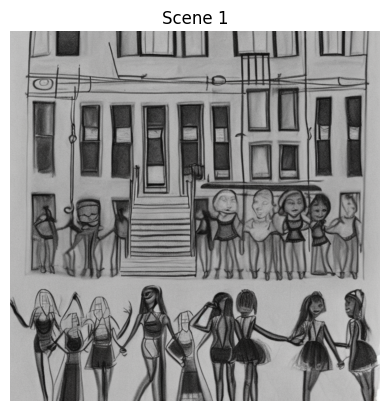

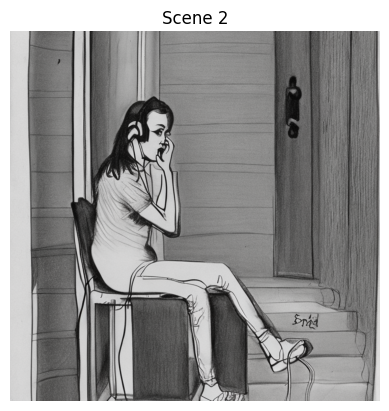

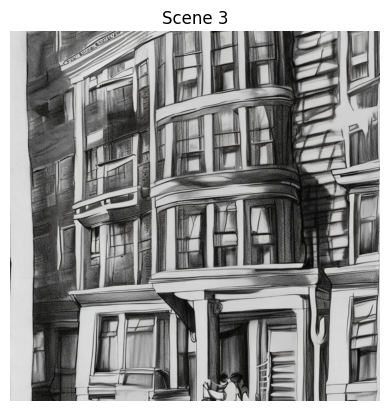

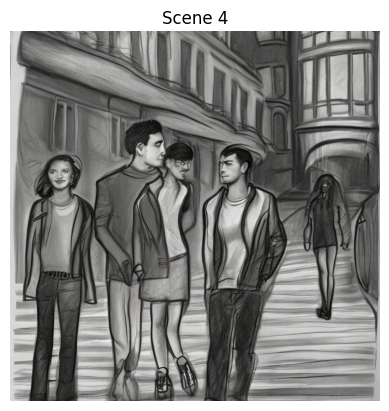

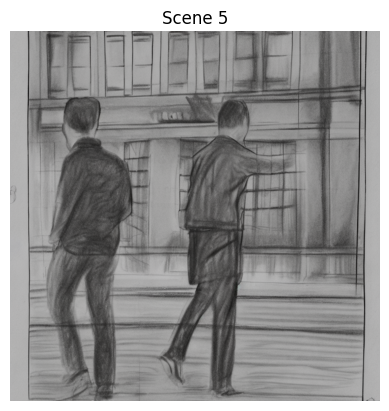

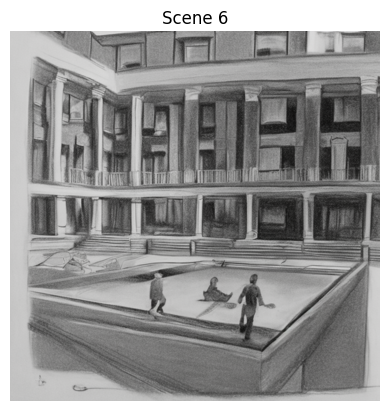

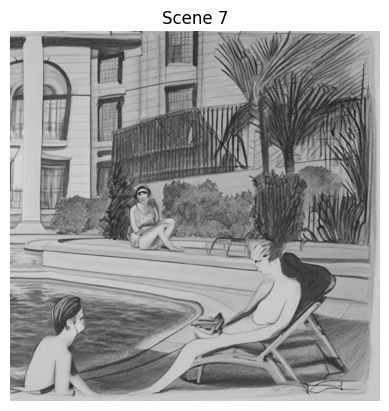

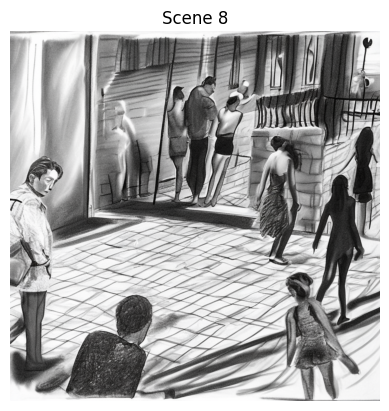

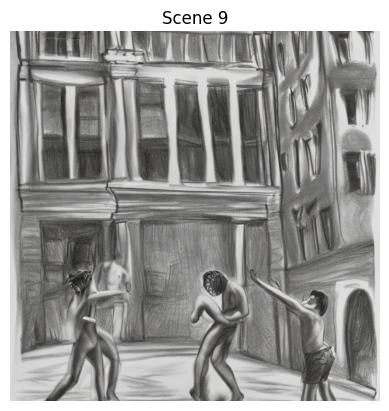

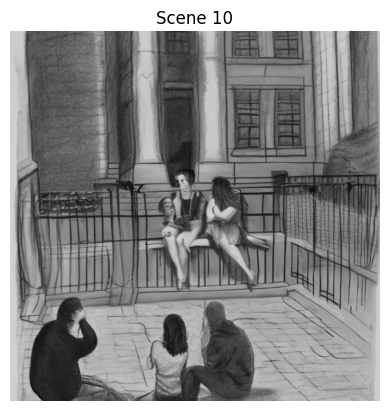

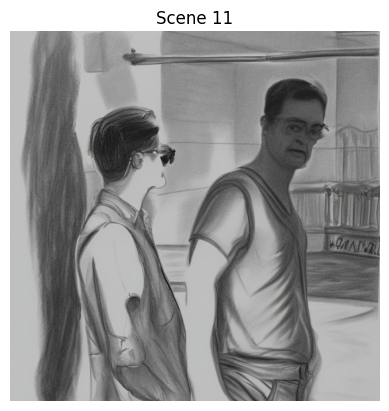

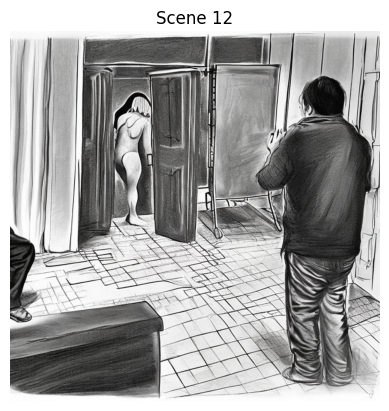

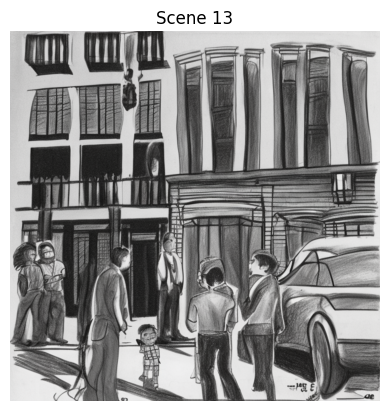

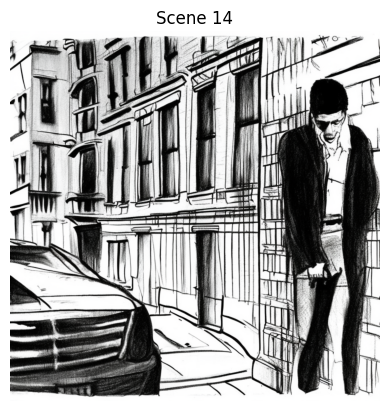

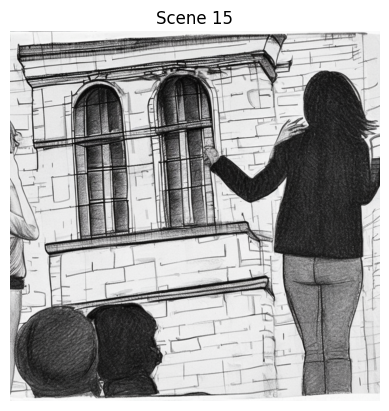

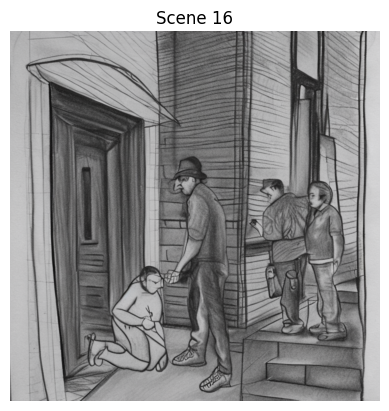

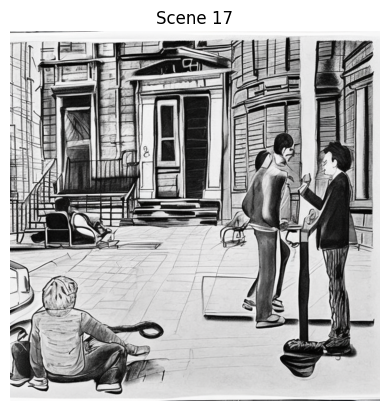

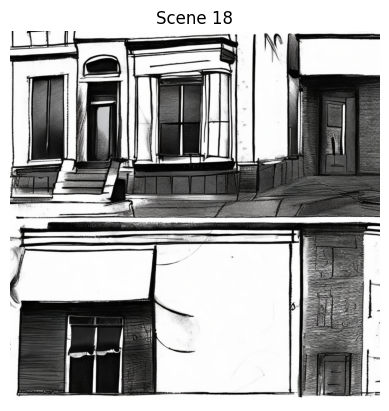

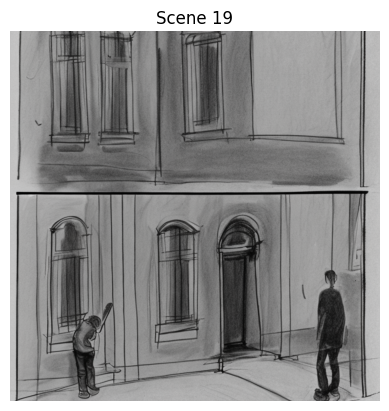

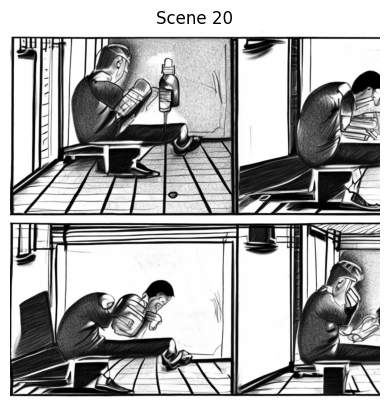

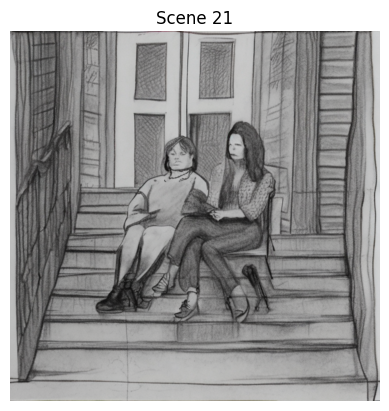

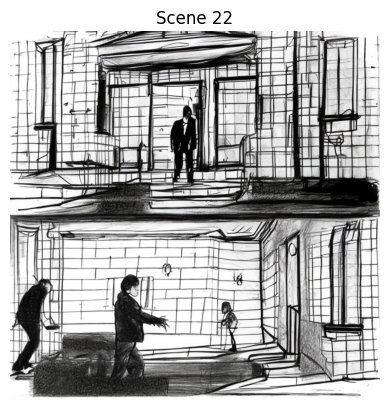

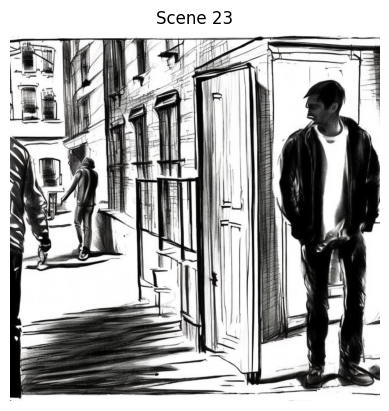

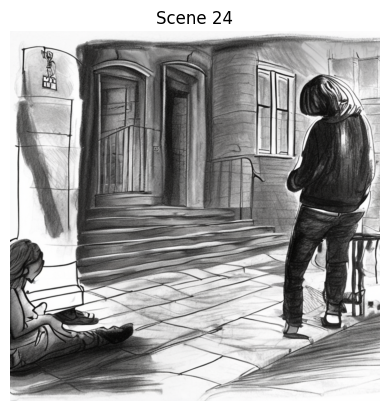

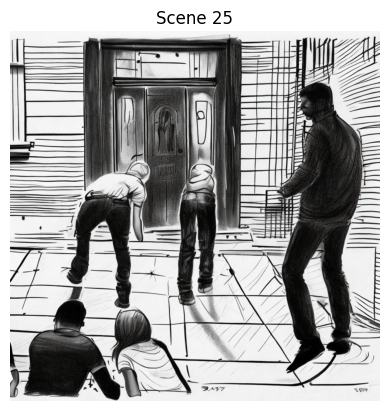

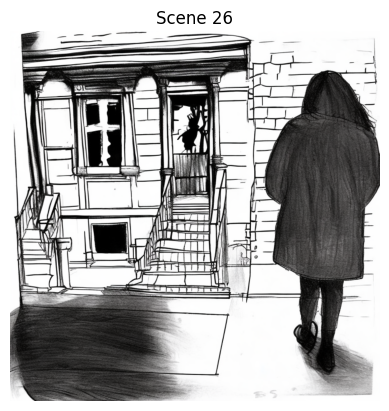

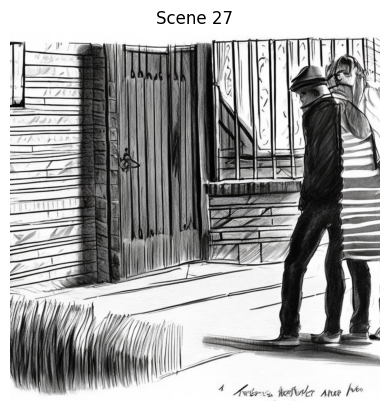

In [ ]:
save_path = os.path.join(drivedir, "Storyboards", "fivefeet")
for n, i in enumerate(images):
  plt.imshow(i)
  plt.axis("off")
  plt.title(f"Scene {n+1}")
  plt.savefig(os.path.join(save_path, f"scene{n+1}.jpg"))
  plt.show()